# DeepEverest example notebook

#### Load the MNIST dataset and VGG16 model.

In [1]:
import os
import numpy as np
from utils import load_mnist_vgg_dataset_model, plot_mnist

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
x_train, y_train, x_test, y_test, model = load_mnist_vgg_dataset_model()
all_layer_names = [layer.name for layer in model.model.layers]
model.model.summary()

Model: "MnistVGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256

### The following preparation is done during pre-processing.

We'll only be using the test set.

In [3]:
dataset = x_test
dataset_labels = y_test
del x_train
del y_train

We'll be examining "activation_12", the last convolutional layer. Feel free to change it to other layers that you're interested.

In [4]:
layer_name = "activation_12"
layer_id = all_layer_names.index(layer_name)

Make sure "python setup_deepeverest_index.py build" is run ahead of time. This is for building the library for building the indexes. Remember to change the library path below for the indexes. See README.md for more details.

In [5]:
import ctypes
lib_file = "/Users/donghe/Desktop/DeepEverest/index/build/lib.macosx-10.7-x86_64-3.7/deepeverst_index.cpython-37m-darwin.so"
index_lib = ctypes.CDLL(lib_file)

Configure some hyperparameters for DeepEverest.

In [6]:
import math
from utils import *

n_images = len(dataset)
n_partitions= 64
batch_size = 64
ratio = 0.05
bits_per_image = math.ceil(math.log(n_partitions, 2))

Get the activation values for our selected layer.

In [7]:
layer_result = get_layer_result_by_layer_id(model, dataset, layer_id, batch_size=batch_size)

Build the indexes in DeepEverest.

In [8]:
from DeepEverest import *

rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx, par_low_bound, par_upp_bound = construct_index(
        index_lib=index_lib,
        n_images=n_images,
        ratio=ratio,
        n_partitions=n_partitions,
        bits_per_image=bits_per_image,
        layer_result=layer_result)

del layer_result

These indexes can be persisted to disk with np.save() or pickle.dump() for convenient & efficient re-use later.

### At query time.

Compute the model's predictions and true labels for the dataset.

In [9]:
label_predicted = np.argmax(model.predict(dataset), axis=1)
label_true = np.argmax(dataset_labels, axis=1)

Find the images that the model mispredicted, from the first 1000 images in the dataset .

In [10]:
misclassified_mask = label_predicted[:1000] != label_true[:1000]
image_ids = np.where(misclassified_mask)[0].tolist()
image_ids

[193, 412, 582, 659, 938]

Let's visualize these misclassified images, with their predicted and true labels.

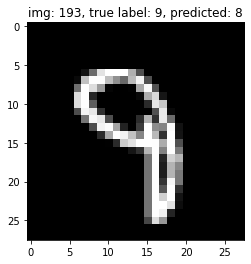

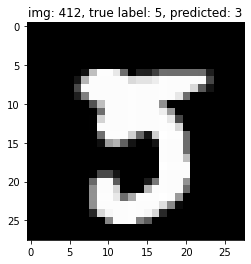

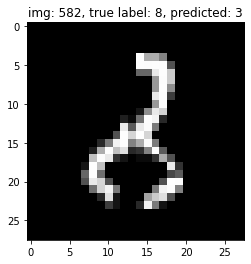

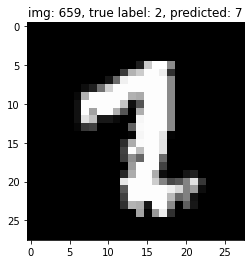

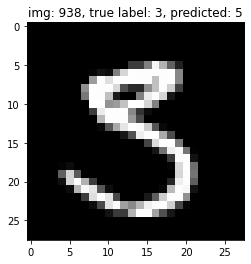

In [11]:
for image_id in image_ids:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_true, image_id, prediction)

The might exist neurons in the layer of interest that have high activation values and lead to the model's misprediction, because of some part of the images has some features. Let's explore this next.

The method below finds the top activation values associated with their neuron identifiers in a given layer, given a set of images.

In [12]:
import heapq


def get_topk_activations_given_images(model, dataset, image_ids, layer_name, k):
    res = list()
    image_samples = list()
    for image_sample_id in image_ids:
        image_samples.append(dataset[image_sample_id])
    layer_result_image_samples = model.get_layer_result_by_layer_name(image_samples, layer_name)
    for idx, image_sample_id in enumerate(image_ids):
        heap = list()
        for neuron_idx, activation in np.ndenumerate(layer_result_image_samples[idx]):
            if len(heap) < k:
                heapq.heappush(heap, (activation, neuron_idx))
            elif (activation, neuron_idx) > heap[0]:
                heapq.heapreplace(heap, (activation, neuron_idx))
        res.append(sorted(heap, reverse=True))
    return res

Let's start with image 659, an image whose true label is 2 but was predicted by the model as 7. We'll find its top-10 activations and the corresponding neuron identifiers.

In [13]:
image_ids = [659]
k_global = 10
topk_activations = get_topk_activations_given_images(model, x_test, image_ids, layer_name, k_global)[0]
topk_activations_neurons = [x[1] for x in topk_activations]
topk_activations

[(2.2470708, (1, 1, 374)),
 (1.9390898, (0, 0, 113)),
 (1.901135, (0, 0, 358)),
 (1.8457981, (1, 0, 335)),
 (1.8241946, (1, 1, 62)),
 (1.7726848, (1, 0, 182)),
 (1.7536622, (1, 1, 129)),
 (1.7496961, (0, 0, 95)),
 (1.7491626, (1, 0, 441)),
 (1.6753774, (1, 1, 177))]

The top-3 activation values are all higher than 1.9. We'll try to explore and understand the functionality of these neurons with DeepEverest by tying that functionality to the input examples in the dataset. We'll first construct a neuron group with these three neurons.

In [14]:
from NeuronGroup import *


image_sample_id = 659
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=topk_activations_neurons[:3])

Find the k-nearest neighbors of image 659 in the dataset using the activation values of a group of neurons based on the proximity in the latent space defined by the group of neurons. `answer_query_with_guarantee` is the key algorithm in DeepEverest, Neural Threshold Algorithm (NTA).

In [15]:
top_k, exit_msg, is_in_partition_0, n_images_rerun = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, 10, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
top_k, exit_msg

image 659, size of neuron group 3
threshold: 0.009085514582693577, max in answer: 0.6309905648231506, images run: 446
threshold: 0.236118346452713, max in answer: 0.5519711375236511, images run: 879
threshold: 0.25425806641578674, max in answer: 0.5519711375236511, images run: 1320
threshold: 0.466907262802124, max in answer: 0.5519711375236511, images run: 1707
threshold: 0.5761293172836304, max in answer: 0.5519711375236511, images run: 2125
======================= NTA exited =======================


([(-0.55197114, 468),
  (-0.5363072, 5649),
  (-0.5042958, 667),
  (-0.37808746, 7902),
  (-0.37677947, 3055),
  (-0.37317905, 5655),
  (-0.33712673, 4176),
  (-0.32671013, 4199),
  (-0.15818709, 3808),
  (0.0, 659)],
 'termination: images run: 2125')

NTA returns the query result without needing to compute the activation values for all the images in the dataset. Only ~2000 images were required to be fed into the model to generate the query result.

Let's visualize these nearest neighbor images.

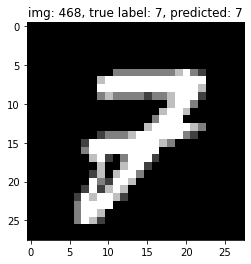

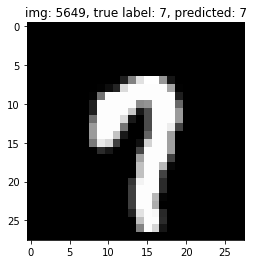

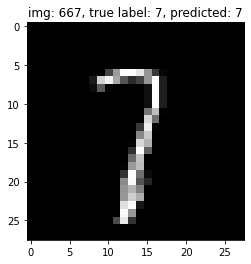

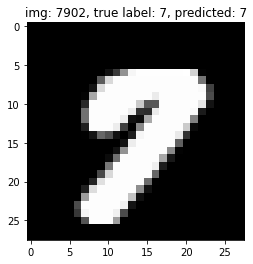

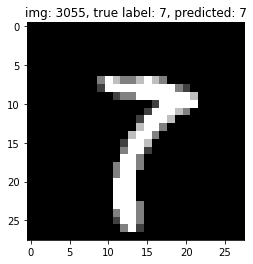

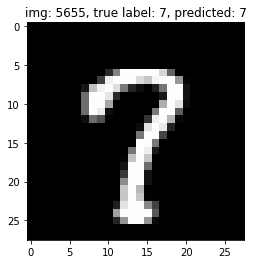

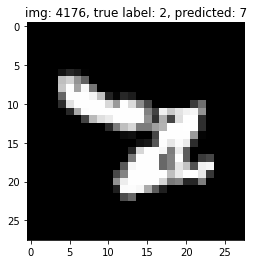

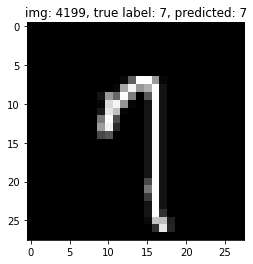

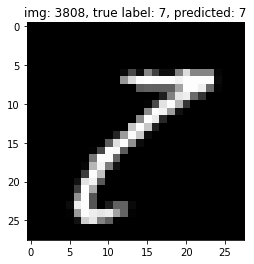

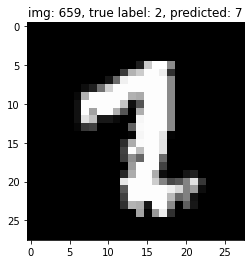

In [16]:
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_true, image_id, prediction)

To help us understand what the neurons are looking at in the image. Below we borrow a technique called [GradCAM](https://arxiv.org/abs/1610.02391?context=cs.AI) that visualizes the regions of input that are "important" for predictions from the model.

In [17]:
from tensorflow.keras.models import Model
import tensorflow as tf
import cv2


class GradCAM:
    def __init__(self, model, layer_name=None):
        """
        model: pre-softmax layer (logit layer)
        """
        self.model = model
        self.layer_name = layer_name

        if self.layer_name == None:
            self.layer_name = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")

    def compute_heatmap(self, image, class_idx, upsample_size, masking=None, eps=1e-5):
        gradModel = Model(
            inputs=[self.model.model.inputs],
            outputs=[self.model.model.get_layer(
                self.layer_name).output, self.model.model.output]
        )

        if masking is None:
            shape = [1] + list(self.model.model.get_layer(self.layer_name).output_shape[1:])
            masking = tf.ones(shape, 'float32')

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = self.model.preprocess_input_for_inference(image)
            (conv_outs, preds) = gradModel(inputs)
            loss = preds[:, class_idx]
            

        # compute gradients with automatic differentiation
        grads = tape.gradient(loss, conv_outs)
        grads = grads * masking
        
        # discard batch
        conv_outs = conv_outs[0]
        grads = grads[0]
        norm_grads = tf.divide(grads, tf.reduce_mean(tf.square(grads)) + tf.constant(eps))
        
        # compute weights
        weights = tf.reduce_mean(norm_grads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, conv_outs), axis=-1)

        # apply ReLU
        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        cam = cv2.resize(cam, upsample_size, interpolation=cv2.INTER_LINEAR)

        # convert to 3D
        cam3 = np.expand_dims(cam, axis=2)
        cam3 = np.tile(cam3, [1, 1, 3])

        return cam3


def overlay_gradCAM(img, cam3):
    cam3 = np.uint8(255 * cam3)
    cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)

    new_img = 0.8 * cam3 + img

    return (new_img * 255.0 / new_img.max()).astype("uint8")


def show_gradCAM(model, gradCAM, img, mask=None):
    fig, axes = plt.subplots(nrows=1, ncols=2)

    axes[0].imshow(img, cmap="gray")
    upsample_size = (img.shape[1], img.shape[0])
    # Show overlayed grad
    x = np.expand_dims(img, axis=0)
    preds = model.predict(x)
    idx = preds.argmax()
    cam3 = gradCAM.compute_heatmap(image=x, class_idx=idx, upsample_size=upsample_size, masking=mask)
    img_overlayed_by_heatmap = overlay_gradCAM(img, cam3)
    img_overlayed_by_heatmap = cv2.cvtColor(img_overlayed_by_heatmap, cv2.COLOR_BGR2RGB)
    axes[1].imshow(img_overlayed_by_heatmap)
    plt.show()

We'll now visualize what the "important" regions are for these three neurons to activate.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



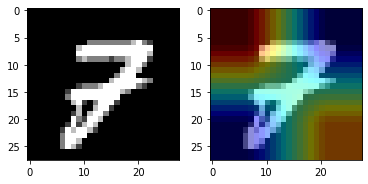

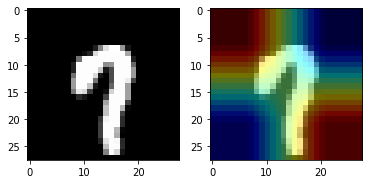

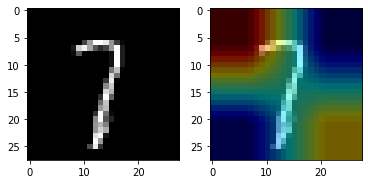

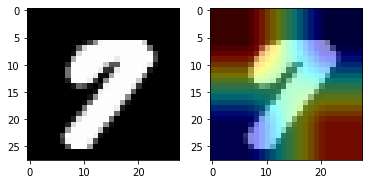

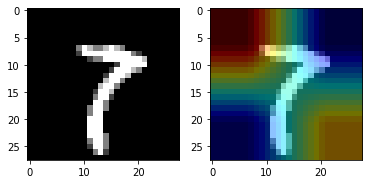

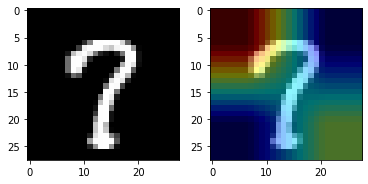

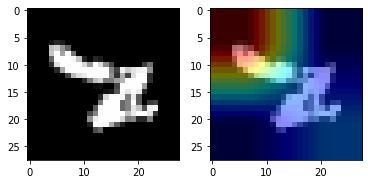

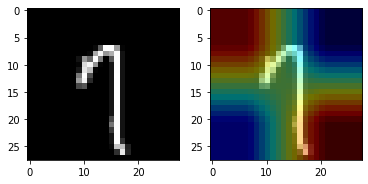

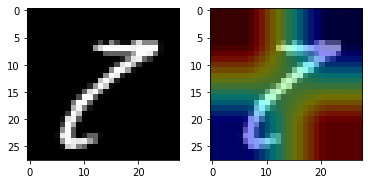

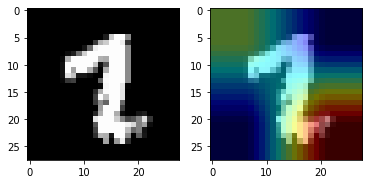

In [18]:
mask = tf.Variable(tf.zeros(shape = list(model.model.get_layer(layer_name).output_shape[1:]), dtype='float32'))
for neuron_idx in neuron_group.neuron_idx_list:
    mask = mask[neuron_idx].assign(1.)
mask = tf.expand_dims(mask, axis=0)

gradCAM = GradCAM(model=model, layer_name=layer_name)
for neg_dist, image_id in top_k:
    show_gradCAM(model, gradCAM, x_test[image_id], mask)


It seems like the misclasiffied images share something in common? Let's visualize what the "important" regions are for whole layer.

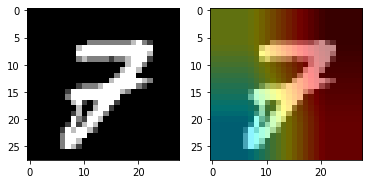

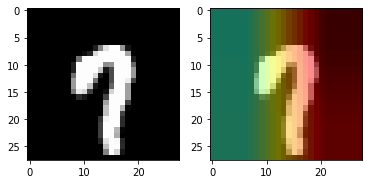

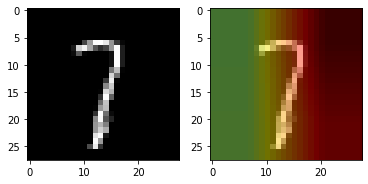

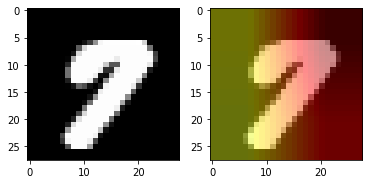

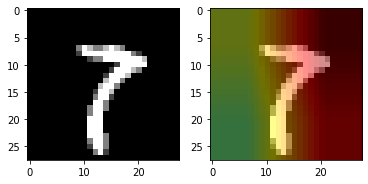

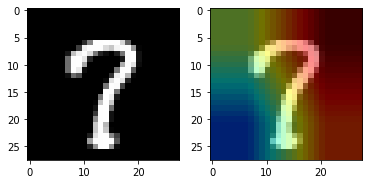

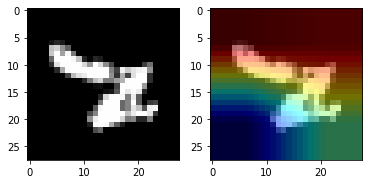

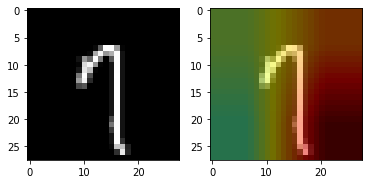

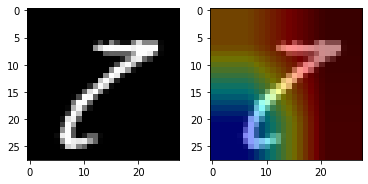

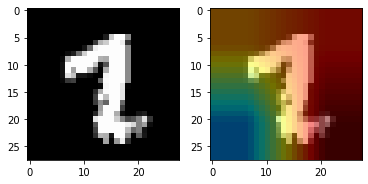

In [19]:
for neg_dist, image_id in top_k:
    show_gradCAM(model, gradCAM, x_test[image_id])

Feel free to explore more using the code below. It explores the common neurons that activate when the model misclassifies 2 as 7 and/or 7 as 2.

In [20]:
def predict_2_as_7(image_id):
    return label_predicted[image_id] == 7 and label_true[image_id] == 2

def predict_7_as_7(image_id):
    return label_predicted[image_id] == 7 and label_true[image_id] == 7

def predict_2_as_2(image_id):
    return label_predicted[image_id] == 2 and label_true[image_id] == 2

def predict_7_as_2(image_id):
    return label_predicted[image_id] == 2 and label_true[image_id] == 7

In [21]:
seven_as_two = -1
two_as_seven = -1
two_as_two = -1
seven_as_seven = -1
for image_id in range(x_test.shape[0]):
    if seven_as_two < 0 and predict_7_as_2(image_id):
        seven_as_two = image_id
    if two_as_seven < 0 and predict_2_as_7(image_id):
        two_as_seven = image_id
    if two_as_two < 0 and predict_2_as_2(image_id):
        two_as_two = image_id
    if seven_as_seven < 0 and predict_7_as_7(image_id):
        seven_as_seven = image_id
    if seven_as_two > 0 and two_as_seven > 0 and two_as_two > 0 and seven_as_seven > 0:
        break

Find two first misclassifications for 7 as 2 and 2 as 7.

In [22]:
image_ids = [two_as_seven, seven_as_two]

Visualize the misclassified images.

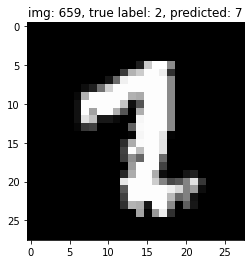

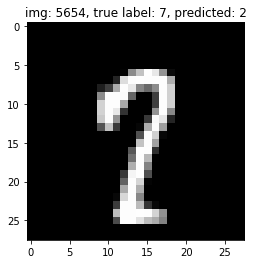

In [23]:
for image_id in image_ids:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_true, image_id, prediction)

Find the top-10 activations associated with their neuron identifiers in the layer of interest for these images.

In [24]:
k_global = 10
topk_activations = get_topk_activations_given_images(model, dataset, image_ids, layer_name, k_global)
topk_activations

[[(2.2470708, (1, 1, 374)),
  (1.9390898, (0, 0, 113)),
  (1.901135, (0, 0, 358)),
  (1.8457981, (1, 0, 335)),
  (1.8241946, (1, 1, 62)),
  (1.7726848, (1, 0, 182)),
  (1.7536622, (1, 1, 129)),
  (1.7496961, (0, 0, 95)),
  (1.7491626, (1, 0, 441)),
  (1.6753774, (1, 1, 177))],
 [(2.48394, (1, 0, 335)),
  (2.4556797, (1, 1, 374)),
  (2.1789901, (0, 0, 45)),
  (2.1284168, (1, 0, 224)),
  (2.079695, (1, 0, 441)),
  (1.9967917, (0, 0, 113)),
  (1.83235, (0, 1, 187)),
  (1.7912123, (0, 1, 285)),
  (1.7750417, (1, 1, 62)),
  (1.7689899, (0, 1, 365))]]

Count the number of times each neuron exists in the top-k activation list.

In [25]:
neuron_cnt = dict()
for topk_activation in topk_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1

sorted_neurons = [(k, v) for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)]
sorted_neurons_idx = [x[0] for x in sorted_neurons]
sorted_neurons

[((1, 1, 374), 2),
 ((0, 0, 113), 2),
 ((1, 0, 335), 2),
 ((1, 1, 62), 2),
 ((1, 0, 441), 2),
 ((0, 0, 358), 1),
 ((1, 0, 182), 1),
 ((1, 1, 129), 1),
 ((0, 0, 95), 1),
 ((1, 1, 177), 1),
 ((0, 0, 45), 1),
 ((1, 0, 224), 1),
 ((0, 1, 187), 1),
 ((0, 1, 285), 1),
 ((0, 1, 365), 1)]

Construct a neuron group that has all the neurons that exist in both top-10 list.

In [26]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=sorted_neurons_idx[:5])

For image `seven_as_two`, find the k-nearest neighbors in the dataset using the activation values of a group of neurons based on the proximity in the latent space defined by the group of neurons; then visualize them.

image 5654, size of neuron group 5
threshold: 0.10119445621967316, max in answer: 0.4580579698085785, images run: 659
threshold: 0.4292418956756592, max in answer: 0.4580579698085785, images run: 1296
threshold: 0.5757235884666443, max in answer: 0.4580579698085785, images run: 1762
======================= NTA exited =======================


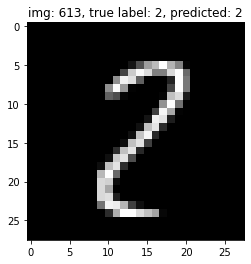

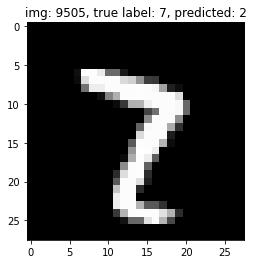

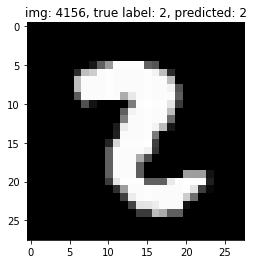

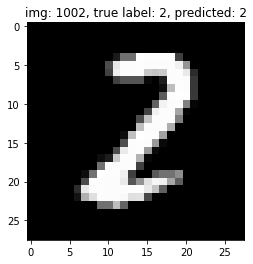

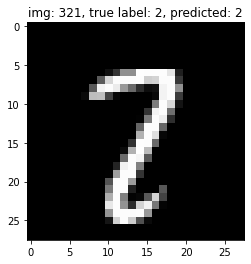

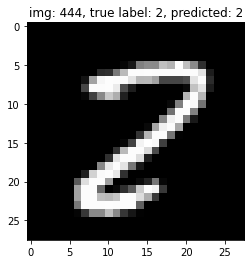

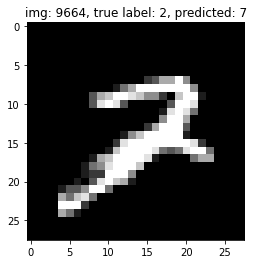

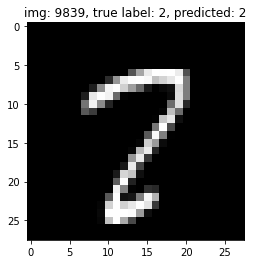

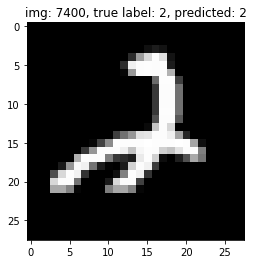

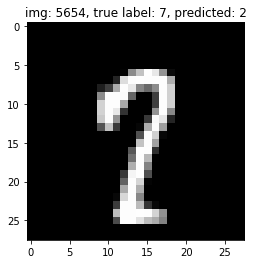

In [27]:
image_sample_id = seven_as_two
top_k, exit_msg, is_in_partition_0, n_images_run = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_true, image_id, prediction)

We have found three "similarly" misclassified images! Then visualize the "important" regions that make this group of neurons activate.

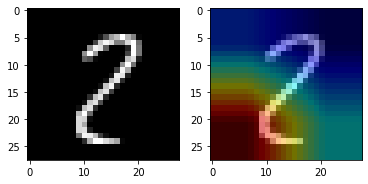

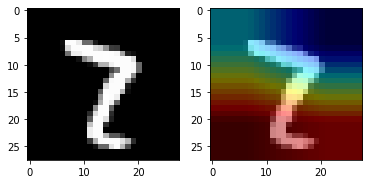

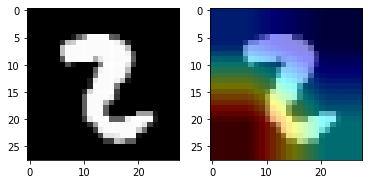

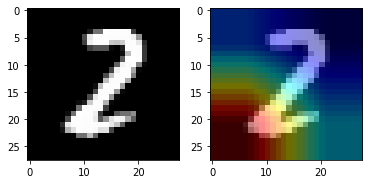

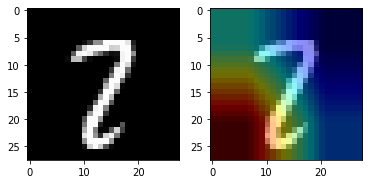

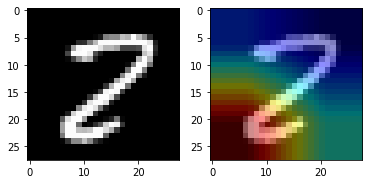

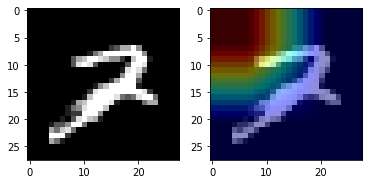

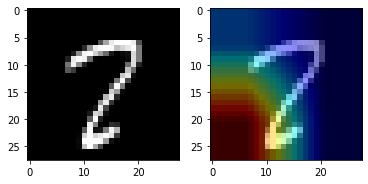

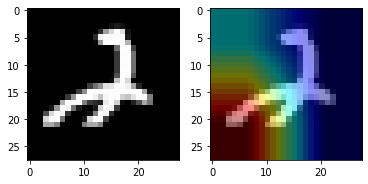

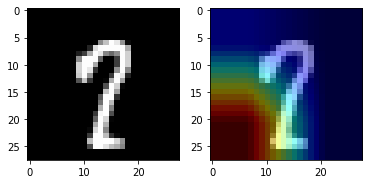

In [28]:
mask = tf.Variable(tf.zeros(shape = list(model.model.get_layer(layer_name).output_shape[1:]), dtype='float32'))
for neuron_idx in neuron_group.neuron_idx_list:
    mask = mask[neuron_idx].assign(1.)
mask = tf.expand_dims(mask, axis=0)

gradCAM = GradCAM(model=model, layer_name=layer_name)
for neg_dist, image_id in top_k:
    show_gradCAM(model, gradCAM, x_test[image_id], mask)

Again, let's see the "important" regions for the whole layer.

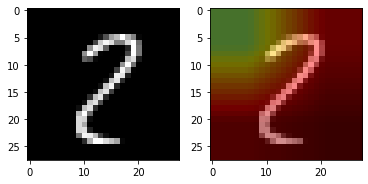

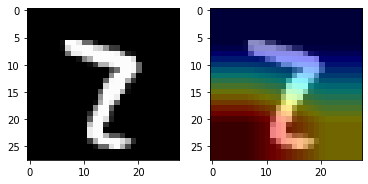

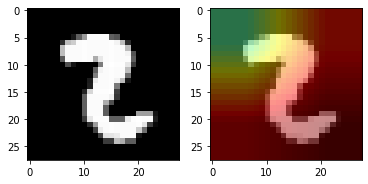

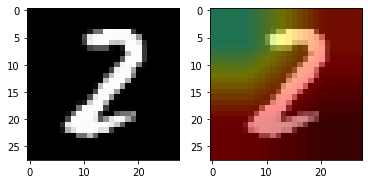

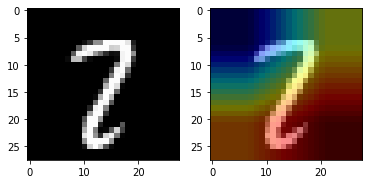

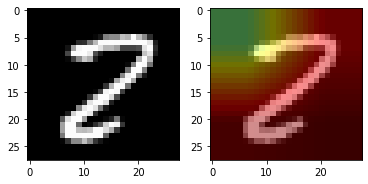

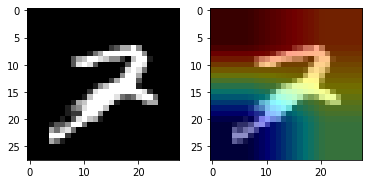

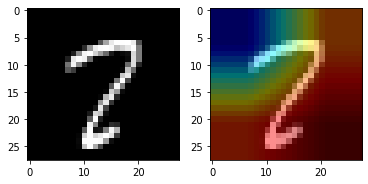

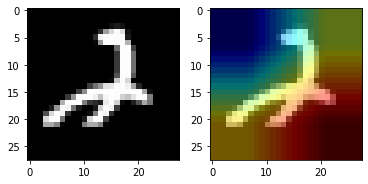

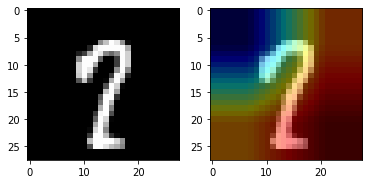

In [29]:
for neg_dist, image_id in top_k:
    show_gradCAM(model, gradCAM, x_test[image_id])